In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd
from numpy import linalg as LA
from scipy.constants import g
import math

4.2 Konvergenzbestimmung

In [51]:
def Anfangsbedigungen(Nx,CFL,verfahren):
    xmax = 10
    xmin = 0
    
    x = np.linspace(xmin, xmax, Nx)
    dx = x[1]-x[0]
    dt = CFL*dx                     # Zeitschrittweite
    t_ende = 5                      # Endzeit
    Nt = int(t_ende/dt)             # Anzahl der Zeitschritte

    #Upwind-Verfahren
    c_positiv = 1*(dt/dx)
    c_negativ = 0

    #Lax-Friedrich / Lax-Wendroff-Verfahren
    c=dt/dx

    # Glatte Anfangsbedingung
    Uo_glatt = np.exp(-2.5*(x-2)**2)

    # Initialisierung der Zustandsmatrix
    U_glatt = np.zeros((Nt+1, Nx))
    U_glatt[0] = Uo_glatt

    # Unstetige Anfangsbedingung
    Uo_unstetig = np.where(np.logical_and(x>=1, x<=3), 1, 0)

    # Initialisierung der Zustandsmatrix
    U_unstetig = np.zeros((Nt+1, Nx))
    U_unstetig[0] = Uo_unstetig

    if verfahren == 'UpWind':
        return U_glatt, U_unstetig, c_positiv, c_negativ, Nt,  Nx #Upwind-Verfahren
    elif verfahren == "Lax-Wendroff": 
        return U_glatt, U_unstetig, c, Nt, Nx #Lax-Wendroff-Verfahren 
    elif verfahren  == "Analytisch":
        return U_glatt, U_unstetig, Nt, Nx, x #Analytische Lösung
    

#Analytische Lösung
def analytisch(CFL,Nx):    
    #Diskretisierung des Gebiets
    xmax = 10 
    xmin = 0
    dx = (xmax-xmin)/Nx 
    x = np.linspace(xmin, xmax, Nx) 
    
    dt = CFL*dx                     # Zeitschrittweite
    t_ende = 5                      # Endzeit
    
    t=0
    while t < t_ende: 
        U_glatt = np.exp(-2.5*(x-t_ende-2)**2)
        U_unstetig = np.where(np.logical_and(x-t_ende>=1, x-t_ende<=3), 1, 0)
        t+=dt
        #Randbedingungen
        U_glatt[0] = 0
        U_glatt[Nx-1] = 0
        U_unstetig[0] = 0
        U_unstetig[Nx-1] = 0
      
    return U_glatt, U_unstetig

def upwind_verfahren(CFL,Nx):

    U_glatt, U_unstetig, c_positiv, c_negativ,Nt, Nx = Anfangsbedigungen(Nx,CFL,verfahren = 'UpWind')
    
    #Lösung des beschriebenen Problems
    for n in range(Nt):
        for i in range(1, Nx-1):
            U_glatt[n+1, i] = U_glatt[n, i] - c_positiv*(U_glatt[n, i] - U_glatt[n, i-1]) + c_negativ*(U_glatt[n, i+1] - U_glatt[n, i])
            U_unstetig[n+1, i] = U_unstetig[n, i] - c_positiv*(U_unstetig[n, i] - U_unstetig[n, i-1]) + c_negativ*(U_unstetig[n, i+1] - U_unstetig[n, i])
            
        #Randbedingungen
        U_glatt[n+1, 0] = 0
        U_glatt[n+1, -1] = 0
        U_unstetig[n+1, 0] = 0
        U_unstetig[n+1, -1] = 0
        
    return U_glatt, U_unstetig

def lax_wendroff(CFL,Nx):
    U_glatt, U_unstetig, c, Nt, Nx = Anfangsbedigungen(Nx,CFL,verfahren = 'Lax-Wendroff')
    #Lösung des beschriebenen Problems
    for n in range(Nt):
        for i in range(1, Nx-1):
            U_glatt[n+1, i] = U_glatt[n, i] - 0.5*c*(U_glatt[n, i+1] - U_glatt[n, i-1]) + 0.5*(c**2)*(U_glatt[n, i+1] - 2*U_glatt[n, i] + U_glatt[n, i-1])
            U_unstetig[n+1, i] = U_unstetig[n, i] - 0.5*c*(U_unstetig[n, i+1] - U_unstetig[n, i-1]) + 0.5*(c**2)*(U_unstetig[n, i+1] - 2*U_unstetig[n, i] + U_unstetig[n, i-1])
        #Randbedingungen
        U_glatt[n+1, 0] = 0
        U_glatt[n+1, -1] = 0
        U_unstetig[n+1, 0] = 0
        U_unstetig[n+1, -1] = 0
    
    return U_glatt, U_unstetig


In [46]:
def konvergenz(CFL, k, norm,verfahren):

        
    U_ana_glatt_k, U_ana_unstetig_k = analytisch(CFL, Nx = 2**(k))
    U_ana_glatt_k1, U_ana_unstetig_k1= analytisch(CFL, Nx = 2**(k+1))
    
    if verfahren == "UpWind":
        U_ver_glatt_k, U_ver_unstetig_k= upwind_verfahren(CFL, Nx = 2**(k))
        U_ver_glatt_k1, U_ver_unstetig_k1= upwind_verfahren(CFL,Nx = 2**(k+1))
        
    elif verfahren == "Lax-Wendroff":
        U_ver_glatt_k, U_ver_unstetig_k= lax_wendroff(CFL, Nx = 2**(k))
        U_ver_glatt_k1, U_ver_unstetig_k1= lax_wendroff(CFL, Nx = 2**(k+1))

    x_k = np.linspace(0, 10, 2**(k))
    dx_k = x_k[1]-x_k[0]

    x_k1 = np.linspace(0, 10, 2**(k+1))
    dx_k1 = x_k1[1]-x_k1[0]

    if norm == np.inf:
        #Experimentelle Konvergenzbestimmung / Quelle: HA4, Gl. 4.37
        EOC_glatt    = (np.math.log(LA.norm((U_ana_glatt_k1    -   U_ver_glatt_k1[-1,:]), ord= norm)) - np.math.log(LA.norm((U_ana_glatt_k    -    U_ver_glatt_k[-1,:]),ord=norm)))/(np.math.log(dx_k1)-np.math.log(dx_k))
        EOC_unstetig = (np.math.log(LA.norm((U_ana_unstetig_k1 - U_ver_unstetig_k1[-1,:]), ord=norm)) - np.math.log(LA.norm((U_ana_unstetig_k - U_ver_unstetig_k[-1,:]),ord=norm)))/(np.math.log(dx_k1)-np.math.log(dx_k))
    else:
        # p-Norm
        dif_glatt_k  = (np.sum((np.abs(U_ana_glatt_k  - U_ver_glatt_k[-1,:]) * dx_k )**norm))*(1/norm)
        dif_glatt_k1 = (np.sum((np.abs(U_ana_glatt_k1 - U_ver_glatt_k1[-1,:])*dx_k1)**norm))*(1/norm)
        EOC_glatt    = (np.math.log(dif_glatt_k1) - np.math.log(dif_glatt_k))/(np.math.log(dx_k1)-np.math.log(dx_k))


        dif_unstetig_k = (np.sum((np.abs(U_ana_unstetig_k   - U_ver_unstetig_k[-1,:])*dx_k )**norm))*(1/norm)
        dif_unstetig_k1 =(np.sum((np.abs(U_ana_unstetig_k1 - U_ver_unstetig_k1[-1,:])*dx_k1)**norm))*(1/norm)
        EOC_unstetig = (np.math.log(dif_unstetig_k1) - np.math.log(dif_unstetig_k))/(np.math.log(dx_k1)-np.math.log(dx_k))

    return EOC_glatt, EOC_unstetig

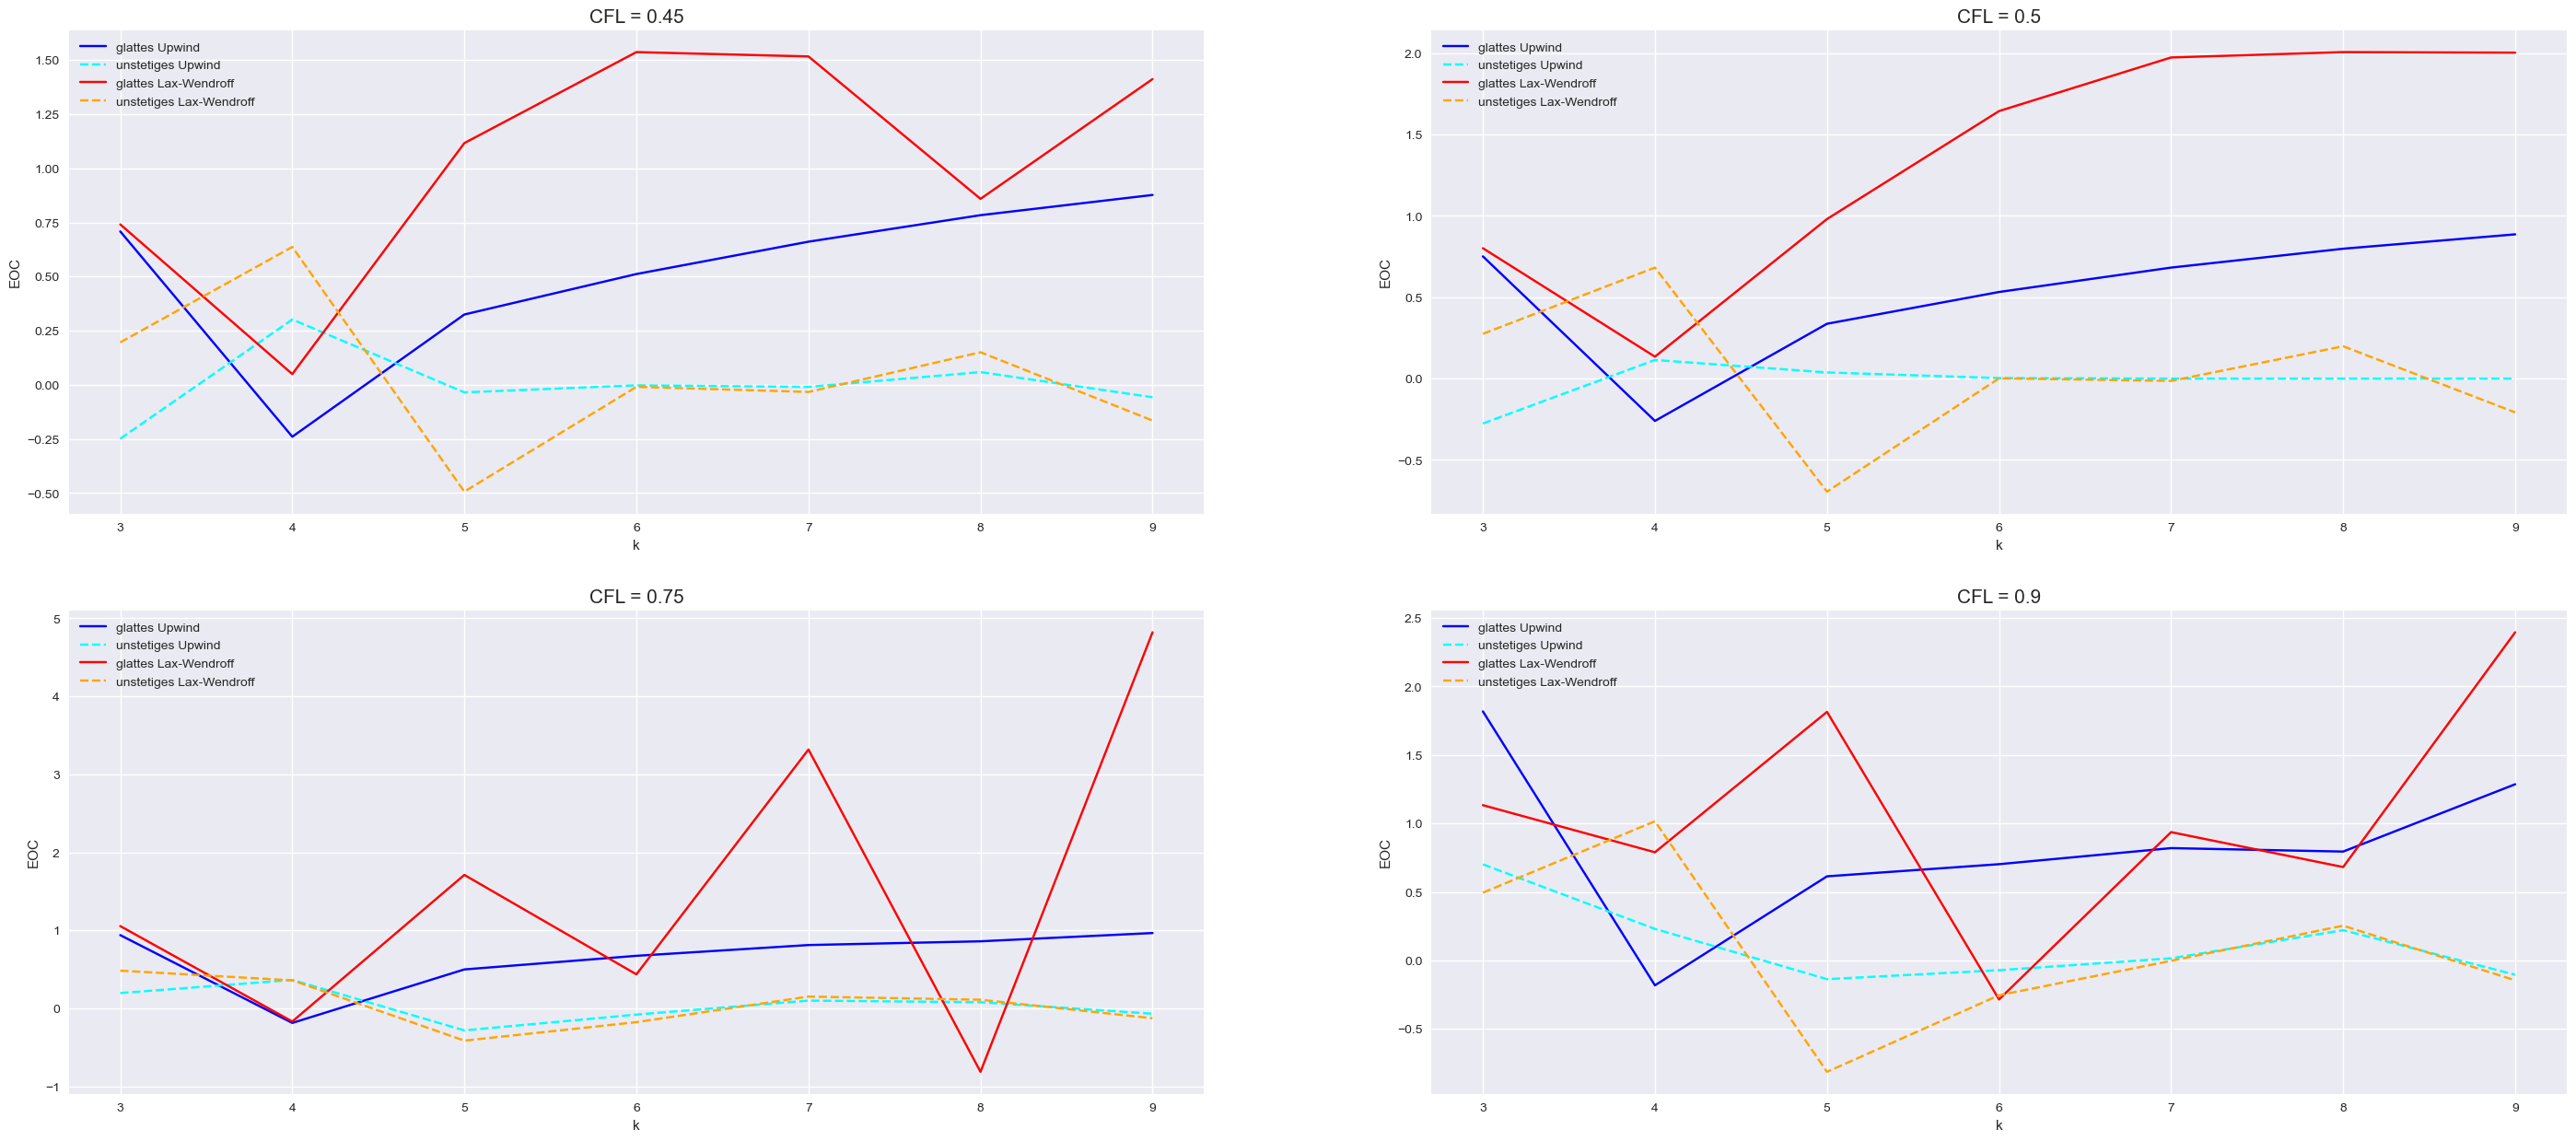

In [53]:
plt.style.use('seaborn')

x = np.array([3,4,5,6,7,8,9])
ks = np.array([3,4,5,6,7,8,9])


norm = np.inf
# norm = 1
#norm = 2

CFLs = [0.45, 0.5, 0.75, 0.9]

fig = plt.figure(figsize=(35, 15))
# fig.suptitle(f'Glatte vs Unstetige Anfangsbedingungen mit Norm = {norm}', fontsize=16)

for CFL in CFLs:
    eoc_glatt_upwind = []
    eoc_unstetig_upwind = []

    eoc_glatt_lax = []
    eoc_unstetig_lax = []
    
    for k in ks:
        # Upwind Verfahren
        EOC_glatt_upwind, EOC_unstetig_upwind = konvergenz(CFL = CFL, k = k, norm = norm, verfahren = "UpWind")
        eoc_glatt_upwind.append(EOC_glatt_upwind)
        eoc_unstetig_upwind.append(EOC_unstetig_upwind)
        
        # Lax-Wendroff Verfahren
        EOC_glatt_lax, EOC_unstetig_lax = konvergenz(CFL = CFL, k = k, norm = norm, verfahren = "Lax-Wendroff")
        eoc_glatt_lax.append(EOC_glatt_lax)
        eoc_unstetig_lax.append(EOC_unstetig_lax)
        
    
    #Subplots
    ax = fig.add_subplot(2,2,i)
    ax.plot(x, eoc_glatt_upwind, color='blue',  label='glattes Upwind')
    ax.plot(x, eoc_unstetig_upwind,'--',color='cyan', label='unstetiges Upwind')
    ax.plot(x, eoc_glatt_lax, color='red', label='glattes Lax-Wendroff')
    ax.plot(x, eoc_unstetig_lax,'--', color= 'orange', label='unstetiges Lax-Wendroff')
    ax.title.set_text(f'CFL = {CFL}')
    ax.title.set_fontsize(15)
    ax.set_xlabel('k')
    ax.set_ylabel('EOC')
    plt.legend()
    
plt.show()  
